### Predictive Maintenance

The goal of the project is to help prevent unplanned downtime by predicting failures before they occur.

The idea is to develop a classification model that predicts the likelihood of a machine failure based on variables like air temperature, process temperature, rotational speed, torque, and tool wear.

The data set for this project is available [here]('https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset).

#### Import Libraries and Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Dataset

In [3]:
df = pd.read_csv('predictive_maintenance.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')

#### Data cleaning and EDA

##### Check for missing values

In [5]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

##### Checking for duplicates

In [6]:
len(df[df.duplicated()])

0

#### Checking for possible outliers

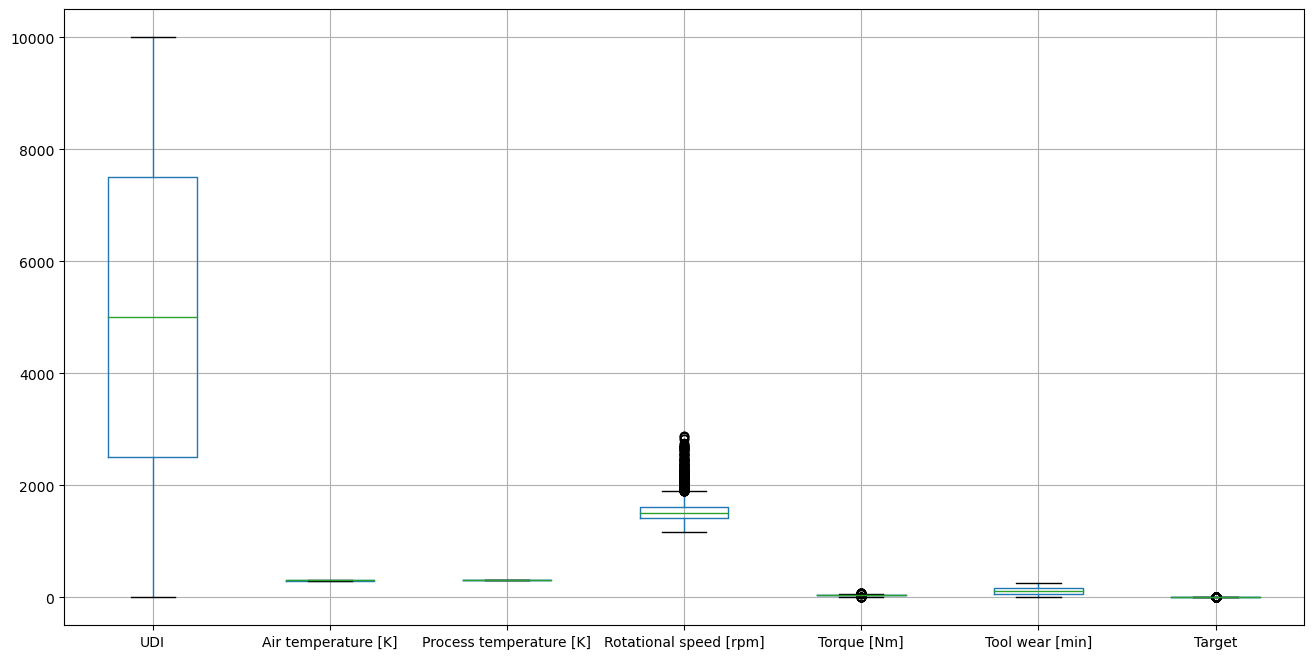

In [10]:
df.boxplot(figsize=(16,8))
plt.show()

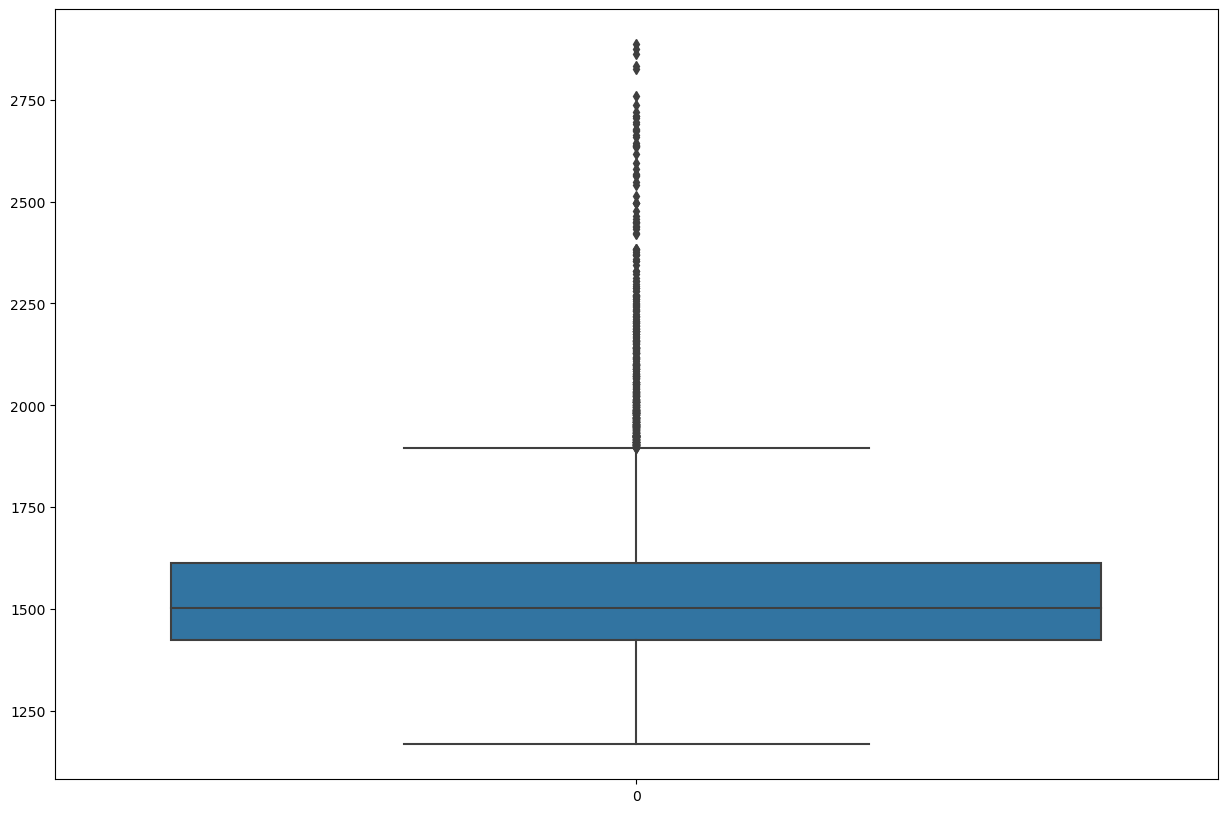

In [8]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df['Rotational speed [rpm]'])
plt.show()

Looks like there are some potentially some extreme records in the 'Rotational Speed' column.

#### Data Pre-processing

In [11]:
df['Product ID'] = df['Product ID'].astype('category')
df['Type'] = df['Type'].astype('category')
df['Failure Type'] = df['Failure Type'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   UDI                      10000 non-null  int64   
 1   Product ID               10000 non-null  category
 2   Type                     10000 non-null  category
 3   Air temperature [K]      10000 non-null  float64 
 4   Process temperature [K]  10000 non-null  float64 
 5   Rotational speed [rpm]   10000 non-null  int64   
 6   Torque [Nm]              10000 non-null  float64 
 7   Tool wear [min]          10000 non-null  int64   
 8   Target                   10000 non-null  int64   
 9   Failure Type             10000 non-null  category
dtypes: category(3), float64(3), int64(4)
memory usage: 922.6 KB


In [12]:
df['Target'].unique()

array([0, 1])

In [13]:
df['Failure Type'].unique()

['No Failure', 'Power Failure', 'Tool Wear Failure', 'Overstrain Failure', 'Random Failures', 'Heat Dissipation Failure']
Categories (6, object): ['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure', 'Power Failure', 'Random Failures', 'Tool Wear Failure']

#### Correlation Matrix

In [14]:
corr = df.corr(numeric_only=True)
corr

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
UDI,1.000000,0.117428,0.324428,-0.006615,0.003207,-0.010702,-0.022892
Air temperature [K],0.117428,1.000000,0.876107,0.022670,-0.013778,0.013853,0.082556
Process temperature [K],0.324428,0.876107,1.000000,0.019277,-0.014061,0.013488,0.035946
Rotational speed [rpm],-0.006615,0.022670,0.019277,1.000000,-0.875027,0.000223,-0.044188
Torque [Nm],0.003207,-0.013778,-0.014061,-0.875027,1.000000,-0.003093,0.191321
Tool wear [min],-0.010702,0.013853,0.013488,0.000223,-0.003093,1.000000,0.105448
Target,-0.022892,0.082556,0.035946,-0.044188,0.191321,0.105448,1.000000


#### Feature Engineering

Create new features from the data in order to improve the model's predictive performance.

In [17]:
#High rotational speed and torque together may contribute to higher stress on the equipment, potentially leading to failure.
df['Power_Stress'] = df['Rotational speed [rpm]'] * df['Torque [Nm]'] 
#A large difference between the air and process temperatures might indicate that the equipment is under high thermal stress, increasing the likelihood of failure.
df['Temperature Difference'] = df['Process temperature [K]'] - df['Air temperature [K]']
# In order to capture trends over time such as fluctuations in speed, rolling average of rotational speed for the last 5 data points
df['Rolling_Avg_Speed'] = df['Rotational speed [rpm]'].rolling(window=15).mean()
#Sudden changes in trends (increasing tool wear ) can indicate deteriorating conditions, which could lead to failures.
df['Rolling_Std_Wear'] = df['Tool wear [min]'].rolling(window=15).std()


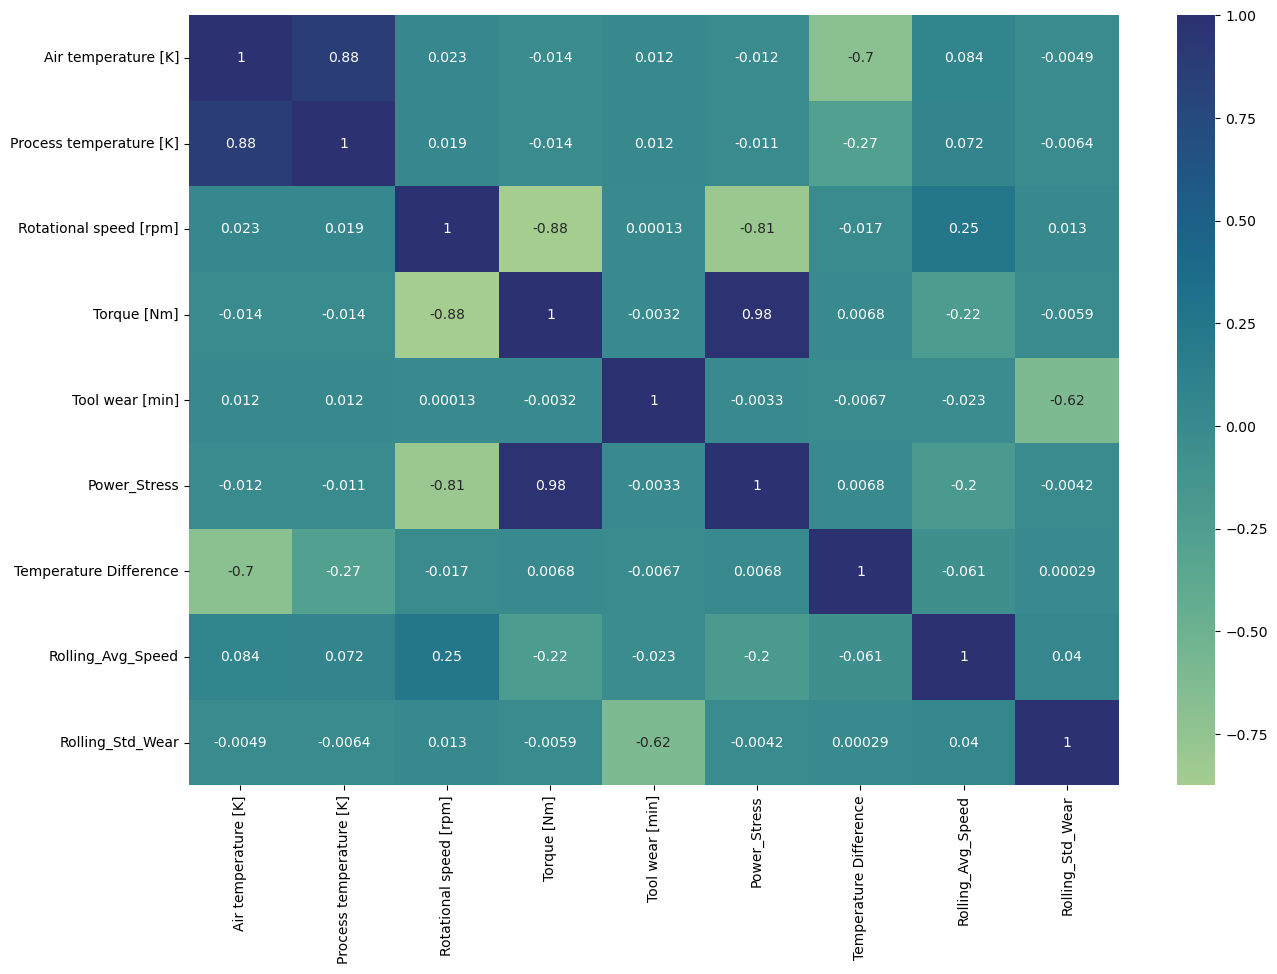

In [49]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(numeric_only=True), annot=True,cmap= 'crest')
plt.show()

**Dropping Unnecessary Columns**

In [22]:
df.drop(columns=['UDI','Product ID','Target'],inplace=True)
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type,Power_Stress,Temperature Difference,Rolling_Avg_Speed,Rolling_Std_Wear
0,M,298.1,308.6,1551,42.8,0,No Failure,66382.8,10.5,NaN,NaN
1,L,298.2,308.7,1408,46.3,3,No Failure,65190.4,10.5,NaN,NaN
2,L,298.1,308.5,1498,49.4,5,No Failure,74001.2,10.4,NaN,NaN
3,L,298.2,308.6,1433,39.5,7,No Failure,56603.5,10.4,NaN,NaN
4,L,298.2,308.7,1408,40.0,9,No Failure,56320.0,10.5,NaN,NaN


In [29]:
df.isna().sum()

Type                        0
Air temperature [K]         0
Process temperature [K]     0
Rotational speed [rpm]      0
Torque [Nm]                 0
Tool wear [min]             0
Failure Type                0
Power_Stress                0
Temperature Difference      0
Rolling_Avg_Speed          14
Rolling_Std_Wear           14
dtype: int64

#### Data Modeling

Splitting the dataset in to trainning and testing

In [36]:
# Drop rows with NaN values in the rolling average and standard deviation columns
df = df.dropna(subset=['Rolling_Avg_Speed', 'Rolling_Std_Wear'])

# Separate the features and target variable
X = df.drop(columns='Failure Type')
y = df['Failure Type']

# Split the dataset into training and testing sets with stratification to handle class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=1)

# Check the shape of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((7489, 10), (2497, 10), (7489,), (2497,))

#### Model Comparisons

The idea here is to capture as many failures as possible, Recall is important metric when missing a failure (false negative) has a high cost as unexpected machine breakdown could lead to production downtime. In industries like manufacturing, missing an equipment failure (false negative) could lead to more significant costs.

Decision Tree recall: 0.98
Random Forest recall: 0.99
K-Nearest Neighbors recall: 0.97
Logistic Regression recall: 0.98
Support Vector Machine recall: 0.97


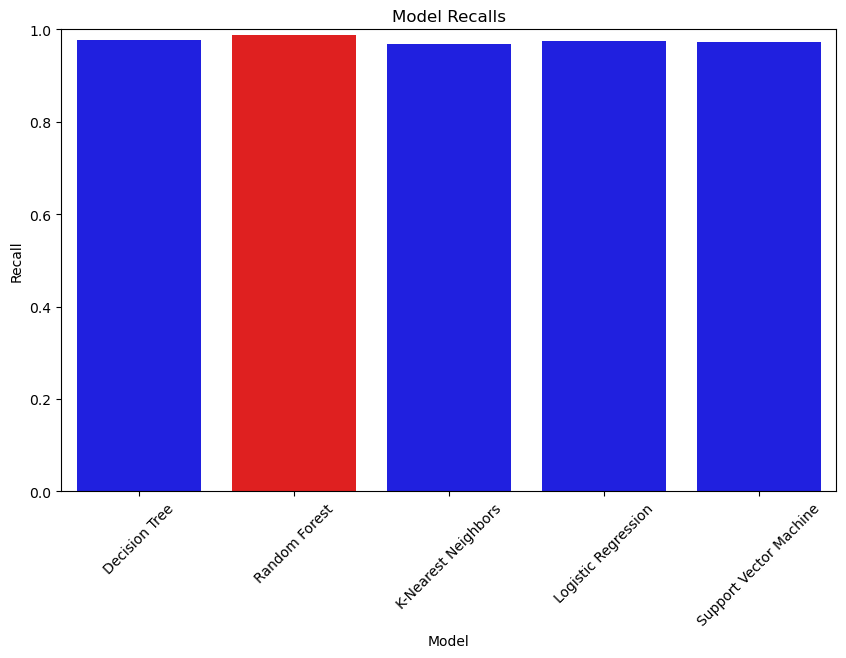

Evaluating Decision Tree...
Classification Report:
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.96      0.86      0.91        28
              No Failure       0.99      0.99      0.99      2410
      Overstrain Failure       0.62      0.75      0.68        20
           Power Failure       1.00      1.00      1.00        24
         Random Failures       0.00      0.00      0.00         4
       Tool Wear Failure       0.13      0.18      0.15        11

                accuracy                           0.98      2497
               macro avg       0.62      0.63      0.62      2497
            weighted avg       0.98      0.98      0.98      2497

Evaluating Random Forest...
Classification Report:
                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      0.79      0.88        28
              No Failure       0.99      1.00      0.99      2410
      Overstrain Failure       0.79 

In [47]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the numerical and categorical columns
num_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
            'Torque [Nm]', 'Tool wear [min]', 'Power_Stress', 'Temperature Difference', 
            'Rolling_Avg_Speed', 'Rolling_Std_Wear']
cat_cols = ['Type']

# Define the pipelines for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OrdinalEncoder(), cat_cols)
    ])

# Apply transformations to training and testing sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Define the models to evaluate
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC(),
}

# Store model names and accuracies for later visualization
model_names = []
recalls = []

# Train and evaluate models based on recall
for name, clf in models.items():
    clf.fit(X_train_processed, y_train)
    y_pred = clf.predict(X_test_processed)
    recall = recall_score(y_test, y_pred, average='weighted')  # Use 'weighted' to handle class imbalance
    model_names.append(name)
    recalls.append(recall)
    print(f"{name} recall: {recall:.2f}")

# Create DataFrame for model recall visualization
df_models = pd.DataFrame({'Model': model_names, 'Recall': recalls})

# Find the index of the champion model (the one with the highest recall)
champion_index = np.argmax(recalls)

# Create a color palette: blue for all, red for the champion model
colors = ['blue' if i != champion_index else 'red' for i in range(len(model_names))]

# Plot model recalls
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Recall', data=df_models, palette=colors)
plt.title('Model Recalls')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

# Display classification reports for each model
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    y_pred = model.predict(X_test_processed)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


The random forest model performed better and had a higher recall score of  99 % and is the champion model for prediction.

In [50]:
RF=RandomForestClassifier().fit(X_train_proccessed,y_train)

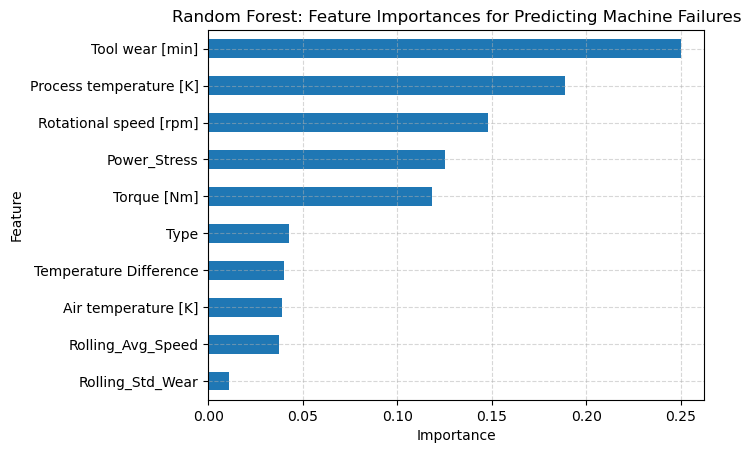

In [52]:
# Get feature importances
feat_impt = RF.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(RF.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]
# create a dataframe and sort it based on importance
y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt}).sort_values("Importance")

# Use a horizontal bar chart for better readability
y_df.plot.barh(x="Feature", y="Importance", title="Random Forest: Feature Importances for Predicting Machine Failures", legend=False)

# It's a good practice to add labels to both axes for clarity.
plt.xlabel("Importance")
plt.ylabel("Feature")

#add line grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Conclusion

Based on the Random Forest classification model, the most important features in predicting machine failures are:
- Tool Wear, 
- Process Temperature , 
- Rotaional Speed, 
- Power Stress 